In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout

2025-01-03 17:34:47.986979: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 17:34:48.148526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-03 17:34:48.150258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-03 17:34:49.445405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
labels = pd.read_csv("./data/samples.csv", dtype={"notes":"str"})
labels.describe()

,idx,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,samples,SR,session_id
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.0,240.0,240.0,240.000000
mean,119.50000,-0.086807,-0.004176,0.031224,-1.612658,-0.035257,1.623447,0.028667,0.0,80896.0,16000.0,12.650000
std,69.42622,0.497664,0.018307,0.074023,0.066449,0.009253,0.105278,0.075707,0.0,0.0,0.0,8.038766
min,0.00000,-1.168625,-0.054549,-0.118711,-1.768377,-0.043390,1.512423,-0.029882,0.0,80896.0,16000.0,0.000000
25%,59.75000,-0.488478,-0.014200,0.000196,-1.654916,-0.042196,1.526472,-0.013382,0.0,80896.0,16000.0,5.750000
50%,119.50000,-0.070474,0.001240,0.003440,-1.574925,-0.040543,1.548387,-0.009352,0.0,80896.0,16000.0,13.000000
75%,179.25000,0.326199,0.007150,0.018959,-1.561053,-0.021722,1.688391,0.066044,0.0,80896.0,16000.0,20.000000
max,239.00000,0.883266,0.038515,0.191562,-1.540088,-0.020854,1.813069,0.324908,0.0,80896.0,16000.0,26.000000


0.8832664489746094

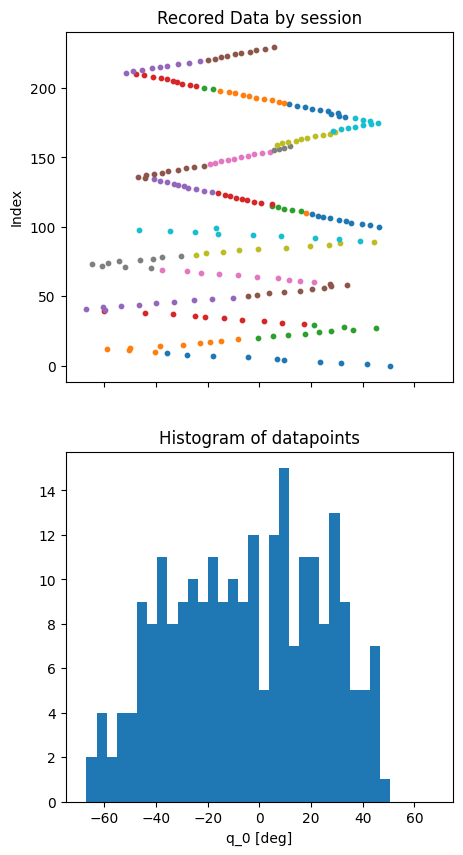

In [5]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5,10))

for sess in range(np.max(labels.session_id)):
    session  = labels[labels.session_id==sess]
    axs[0].scatter(np.rad2deg(session.q_0), session.idx, s=10)

axs[0].set_title("Recored Data by session")
axs[0].set_ylabel("Index")

axs[1].hist(np.rad2deg(labels.q_0), bins=30)
axs[1].set_title("Histogram of datapoints")
axs[1].set_xlabel("q_0 [deg]")
plt.xlim((-75,75))
labels.iloc[0].q_0

In [7]:
import scipy.io.wavfile
import os

inputpath = "./data"
inputlength =  5
SR = 16000
outputlength = 4096//2
applyFFT = True

inputfiles = os.listdir(inputpath)

split_into = (inputlength * SR // outputlength)
output_datapoints = len(inputfiles) * split_into
req_inputlength = split_into * outputlength

X_long = np.zeros((0,80896))

print(f"Splitting each input into {split_into} datapoints, resulting in {output_datapoints} samples")

X = np.zeros((output_datapoints, outputlength))
y = np.full((output_datapoints, 2), np.nan)

for i, file in enumerate(inputfiles):
    if file.split(".")[1] != "wav":
        continue
    sr, data = scipy.io.wavfile.read(inputpath + "/" + file)
    idx = int(file.split(".")[0])
    if sr != SR:
        raise(f"Samplerate of {file} is {sr} instead of {SR}")

    if len(data) < req_inputlength:
        raise(f"File {file} is not long enough")

    X_long = np.vstack((X_long, data[:,0]))

    start_of_block = (len(data) - req_inputlength) // 2
    data_block = data[start_of_block:start_of_block+req_inputlength, 1]
    X[i*split_into:(i+1)*split_into, :] = data_block.reshape((split_into, outputlength))
    y[i*split_into:(i+1)*split_into, :] = np.array((idx, labels.iloc[idx].q_0))

if applyFFT:
    # TODO Hamming (or other) window?
    print("applying FFT")
    X = np.abs(np.fft.rfft(X))

Splitting each input into 39 datapoints, resulting in 9438 samples
applying FFT


[Text(0.5, 0, 'frequency')]

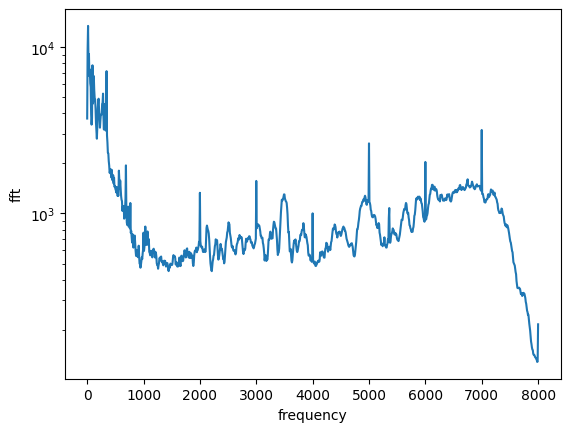

In [8]:
sample_rate = 16000
freq = np.fft.rfftfreq(outputlength, d=1./sample_rate)


plt.plot(freq, np.average(X, axis=0))

plt.yscale("log")
plt.ylabel("fft")
plt.gca().set(xlabel="frequency")

In [9]:
rng = np.random.default_rng(0)
train_fraction = 0.7
train_idx = rng.choice(np.arange(len(labels)), int(len(labels)*train_fraction), replace=False)
train_samples = int(train_fraction*len(X))

X_train = np.zeros((0, X.shape[1]))
X_test = np.zeros((0, X.shape[1]))
y_train = np.zeros((0,))
y_test = np.zeros((0, ))
for idx in range(len(labels)):
    indizes = y[:,0] == idx
    if idx in train_idx:
        X_train = np.vstack((X_train, X[indizes]))
        y_train = np.hstack((y_train, y[indizes,1]))
    else:
        X_test = np.vstack((X_test, X[indizes]))
        y_test = np.hstack((y_test, y[indizes,1]))

In [10]:
# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
def evaluate_model(model, X_test, y_test, model_name):

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    y_pred_deg = np.rad2deg(y_pred)
    y_test_deg = np.rad2deg(y_test)

    mse_deg = mean_squared_error(y_test_deg, y_pred_deg)
    # RMSE since MSE is high due to unit difference
    rmse_deg = np.sqrt(mse_deg)

    print(f"{model_name} - Mean Squared Error (radians): {mse:.4f}")
    print(f"{model_name} - Mean Squared Error (degrees): {mse_deg:.4f}")
    print(f"{model_name} - Root Mean Squared Error (degrees): {rmse_deg:.4f}")
    print(f"{model_name} - R2 Score: {r2:.4f}")

    plt.figure(figsize=(7, 7))
    plt.scatter(y_test_deg, y_pred_deg, label="Predictions")
    plt.plot((-70,50), (-70,50), color="orange", label="Ground Truth")
    plt.xlabel("True Joint Angle (deg)")
    plt.ylabel("Predicted Joint Angle (deg)")
    plt.title(f"{model_name} - Predictions vs Ground Truth")
    plt.legend()
    plt.show()

2025-01-03 17:38:21.636794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-03 17:38:22.446401: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21488100 exceeds 10% of free system memory.


Epoch 1/50
164/164 [==============================] - 2s 5ms/step - loss: 2.7425 - val_loss: 0.1320
Epoch 2/50
164/164 [==============================] - 1s 4ms/step - loss: 0.4883 - val_loss: 0.1517
Epoch 3/50
164/164 [==============================] - 1s 4ms/step - loss: 0.4623 - val_loss: 0.0950
Epoch 4/50
164/164 [==============================] - 1s 4ms/step - loss: 4.1065 - val_loss: 0.0931
Epoch 5/50
164/164 [==============================] - 1s 4ms/step - loss: 1.1013 - val_loss: 0.0972
Epoch 6/50
164/164 [==============================] - 1s 4ms/step - loss: 1.2458 - val_loss: 0.0607
Epoch 7/50
164/164 [==============================] - 1s 4ms/step - loss: 0.7168 - val_loss: 0.0722
Epoch 8/50
164/164 [==============================] - 1s 4ms/step - loss: 3.5917 - val_loss: 0.0522
Epoch 9/50
164/164 [==============================] - 1s 4ms/step - loss: 3.5441 - val_loss: 0.0484
Epoch 10/50
164/164 [==============================] - 1s 4ms/step - loss: 3.9446 - val_loss: 0.0588

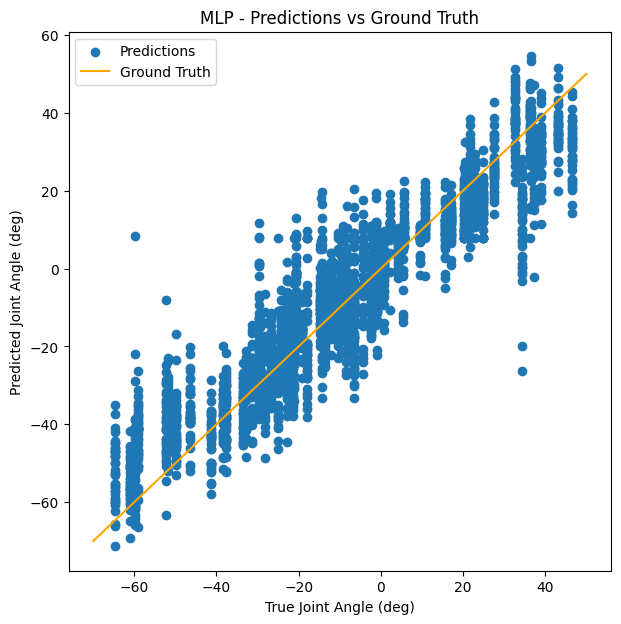

In [12]:
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])
mlp_model.compile(optimizer='adam', loss='mse')
mlp_mod = mlp_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
evaluate_model(mlp_model, X_test, y_test, "MLP")

Epoch 1/50


2025-01-03 17:39:50.177746: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21488100 exceeds 10% of free system memory.


164/164 [==============================] - 11s 60ms/step - loss: 0.2670 - val_loss: 0.1863
Epoch 2/50
164/164 [==============================] - 8s 46ms/step - loss: 0.0635 - val_loss: 0.0331
Epoch 3/50
164/164 [==============================] - 8s 47ms/step - loss: 0.0183 - val_loss: 0.0330
Epoch 4/50
164/164 [==============================] - 7s 45ms/step - loss: 0.0132 - val_loss: 0.0253
Epoch 5/50
164/164 [==============================] - 7s 45ms/step - loss: 0.0142 - val_loss: 0.0275
Epoch 6/50
164/164 [==============================] - 7s 44ms/step - loss: 0.0128 - val_loss: 0.0302
Epoch 7/50
164/164 [==============================] - 8s 46ms/step - loss: 0.0087 - val_loss: 0.0278
Epoch 8/50
164/164 [==============================] - 8s 48ms/step - loss: 0.0084 - val_loss: 0.0327
Epoch 9/50
164/164 [==============================] - 8s 46ms/step - loss: 0.0080 - val_loss: 0.0306
Epoch 10/50
164/164 [==============================] - 7s 45ms/step - loss: 0.0071 - val_loss: 0.0295

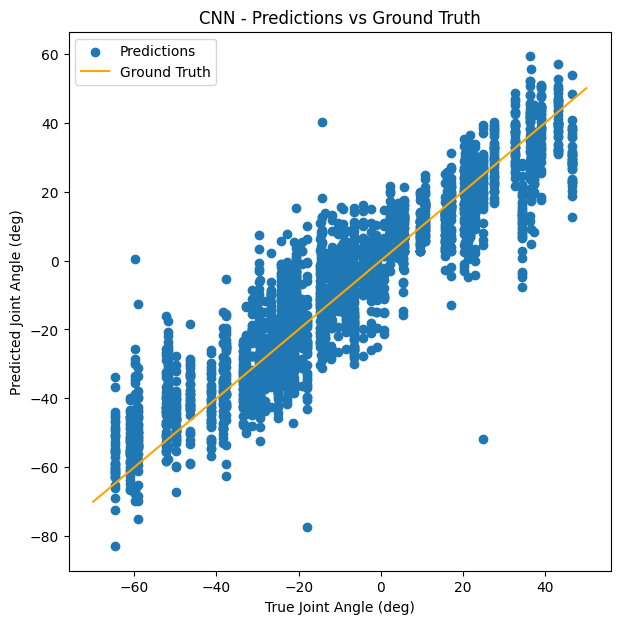

In [13]:
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')
cnn_mod = cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
evaluate_model(cnn_model, X_test_cnn, y_test, "CNN")

88/88 [==============================] - 1s 8ms/step


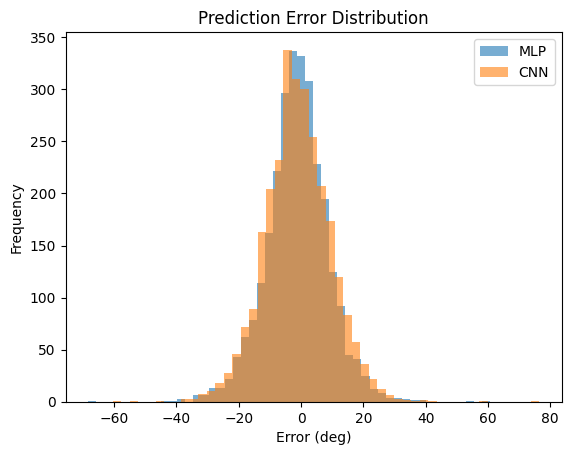

In [14]:
models = [mlp_model, cnn_model]
model_names = ["MLP", "CNN"]
errors = []

for model, name in zip(models, model_names):
    if name == "MLP":
        X_test_model = X_test
    elif name == "CNN":
        X_test_model = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    y_pred = model.predict(X_test_model)
    error = np.rad2deg(y_test - y_pred.flatten())
    errors.append(error)

    plt.hist(error, bins=50, alpha=0.6, label=name)

plt.xlabel("Error (deg)")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.legend()
plt.show()

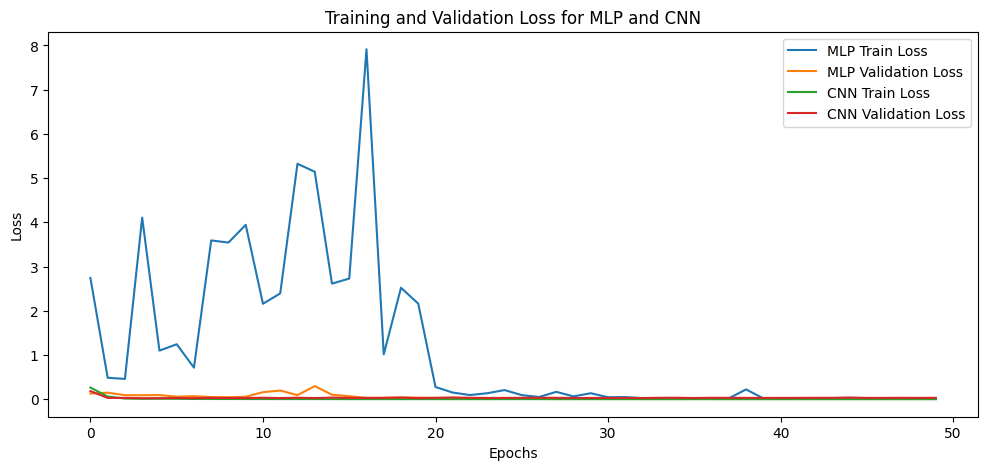

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(mlp_mod.history['loss'], label='MLP Train Loss')
plt.plot(mlp_mod.history['val_loss'], label='MLP Validation Loss')
plt.plot(cnn_mod.history['loss'], label='CNN Train Loss')
plt.plot(cnn_mod.history['val_loss'], label='CNN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss for MLP and CNN')
plt.show()